In [1]:
import os
USE_GOOGLE_DRIVE = False
MOUNT_GDIR = "/content/gdrive/MyDrive/Colab Notebooks/game_simulation"

def mount_google_drive():
    from google.colab import drive
    mount_directory = "/content/gdrive"
    drive.mount(mount_directory)
    return None

if USE_GOOGLE_DRIVE:
    mount_google_drive()
    os.chdir(MOUNT_GDIR)

#if os.getcwd() != MOUNT_GDIR:
#    os.chdir(MOUNT_GDIR)
print(os.getcwd())


/home/niels/FileSynchronization/Nextcloud/python_codes


In [4]:
MULTIPROCESSING = False
PARALLEL_COMPUTING = False

if MULTIPROCESSING:
    import multiprocessing as mp
    print(mp.cpu_count())

if PARALLEL_COMPUTING: 
    from ipyparallel import Client
    rc = Client(profile="default")
    dv = rc[:]  # dv = rc.load_balanced_view()
    print(rc.ids)
    with dv.sync_imports():
        import numpy as np
        from player import Player
        from mall import Mall
        from house import House
        import matplotlib.pyplot as plt

if not PARALLEL_COMPUTING: 
    import numpy as np
    from player import Player
    from mall import Mall
    from house import House
    import matplotlib.pyplot as plt
    
%matplotlib inline


In [5]:
from datetime import datetime
today = datetime.now()
output_dir = today.strftime('%Y%m%d%H%M%S')
if not os.path.isdir(output_dir):
    os.mkdir(today.strftime('%Y%m%d%H%M%S'))
else:
    print("Target directory exits!")

In [6]:
%%time
for _ in range(20):
    my = Player(100000)
    print(my.Bernoulli_p)

1/100000
33333/100000
1/4
33333/100000
1/2
1/10


1/4
33333/100000
1/100000
1/2
33333/100000
1/2


1/10
33333/100000
1/100000
1/4
1/2
33333/100000
1/2


1/100000
CPU times: user 632 ms, sys: 60.7 ms, total: 692 ms
Wall time: 728 ms


In [7]:
def plot_edge_history(mall_ls, total_interval, upper_bound=None, lower_bound=None, house_action_label=''):
    fig = plt.figure()
    for m in mall_ls:
        plt.plot(m.edge_history)

    if upper_bound:
        plt.plot(np.zeros(total_interval) + upper_bound, "k--")
    if lower_bound:
        plt.plot(np.zeros(total_interval) + lower_bound, "k--")

    plt.grid(True)
    plt.xlabel("intervals")
    plt.ylabel("edge")
    if house_action_label:
        plt.title(str(len(mall_ls))+' mall(s)'+' under '+ house_action_label)
    else:
        plt.title(str(len(mall_ls))+' mall(s)')
    
    fig.savefig(output_dir+"/"+"edge_history_"+str(n_action)+"_actions_"+str(n_mall)+"_malls"+"_under_"+house_action_label+".png")    
    return fig

def plot_final_edge(mall_ls, total_interval, upper_bound=None, lower_bound=None, house_action_label=''):
    fig = plt.figure()
    plt.bar([i for i in range(n_mall)], np.array([m.edge_history[-1] for m in mall_ls]), align="edge")
    #plt.bar([i+0.5 for i,_ in enumerate(mall_id)], np.array([m.edge_history[-1] for m in mall_ls]))
    plt.plot(np.zeros(n_mall+1) + upper_bound, "k--")
    plt.plot(np.zeros(n_mall+1) + lower_bound, "k--")
    plt.xlabel("mall_id")
    plt.ylabel("Final_edge")
    fig.savefig(output_dir+"/"+"final_edge_"+str(n_action)+"_actions_"+str(n_mall)+"_malls"+"_under_"+house_action_label+".png")    
    return fig

def plot_edge_convergence(mall_ls, total_interval, upper_bound=None, lower_bound=None, house_action_label='', method='in_out'):
    fig = plt.figure()
    if method == "in_out":
       out_target = [list(map(lambda x:x < lower_bound or x > upper_bound, m.edge_history)) for m in mall_ls]
       plt.plot(np.mean(out_target, axis=0))
       plt.ylabel("out_target_ratio")
    elif method == "abs":
       out_target_abs = [list(map(lambda x:lower_bound - x if x < lower_bound else
                                  x-upper_bound if  x > upper_bound else 0, m.edge_history))
                         for m in mall_ls
       ]
       plt.plot(np.mean(out_target_abs, axis=0))
       plt.ylabel("mean_distance_of_order_1")
    else:
        print("Something odd! Figure out this!")
        assert True == False

    plt.plot(np.zeros(total_interval), "k--")

    plt.grid(True)
    plt.xlabel("intervals")
    
    if house_action_label:
        plt.title(str(len(mall_ls))+' mall(s)'+' under '+ house_action_label)
    else:
        plt.title(str(len(mall_ls))+' mall(s)')
    fig.savefig(output_dir+"/"+"convergence_"+str(n_action)+"_actions_"+str(n_mall)+"_malls"+"_under_"+house_action_label+"_"+method+".png")        
    return fig

In [8]:
def game_run_choice_func_random_action(total_interval, n_action, n_mall, house_action_label="random"):
    mall_ls = [Mall() for _ in range(n_mall)]
    house = House(n_action)
    for t in range(total_interval):
        for m in mall_ls:
            m.player_betting(n_action)

        house.get_interval(t)
        house_action = house.choice_func_random_action(mall_ls)

        for m in mall_ls:
            m.update_for(house_action, house.random_action)
            m.edge_record()
    final_edge_ls = [m.edge_history[-1] for m in mall_ls]
    print(f"final edges:{final_edge_ls}")
    plot_edge_history(mall_ls, total_interval, None, None, house_action_label)
 #   fig.savefig(output_dir+"/"+"test_for_"+str(n_action)+"_actions_"+str(n_mall)+"_malls"+"_under_"+house_action_label+".png")
    plot_edge_convergence(mall_ls, total_interval, upper_bound, lower_bound, house_action_label, method="in_out")
    plot_edge_convergence(mall_ls, total_interval, upper_bound, lower_bound, house_action_label, method="abs")
    plot_final_edge(mall_ls, total_interval, upper_bound, lower_bound, house_action_label)

    return None

def game_run_choice_func_1(total_interval, n_action, n_mall, upper_bound, lower_bound, house_action_label='C_Func_1'):
    mall_ls = [Mall() for _ in range(n_mall)]
    house = House(n_action)
    for t in range(total_interval):
        for m in mall_ls:
            m.player_betting(n_action)

        house.get_interval(t)
        house_action = house.choice_func_1(mall_ls, upper_bound, lower_bound)

        for m in mall_ls:
            m.update_for(house_action, house.random_action)
            m.edge_record()
    final_edge_ls = [m.edge_history[-1] for m in mall_ls]
    print(f"final edges:{final_edge_ls}")
   # plot_edge_history(mall_ls)
    plot_edge_history(mall_ls, total_interval, upper_bound, lower_bound, house_action_label)
   # fig.savefig(output_dir+"/"+"test_for_"+str(n_action)+"_actions_"+str(n_mall)+"_malls"+"_under_"+house_action_label+".png")
    plot_edge_convergence(mall_ls, total_interval, upper_bound, lower_bound, house_action_label, method="in_out")
    plot_edge_convergence(mall_ls, total_interval, upper_bound, lower_bound, house_action_label, method="abs")
    plot_final_edge(mall_ls, total_interval, upper_bound, lower_bound, house_action_label)        
    return None

def game_run_choice_func_2(total_interval, n_action, n_mall, upper_bound, lower_bound, P, Q, house_action_label='C_Func_2'):
    mall_ls = [Mall() for _ in range(n_mall)]
    house = House(n_action)
    for t in range(total_interval):
        for m in mall_ls:
            m.player_betting(n_action)

        
        house.get_interval(t)
        house_action = house.choice_func_2(mall_ls, upper_bound, lower_bound, P, Q)
    
        for m in mall_ls:
            m.update_for(house_action, house.random_action)
            m.edge_record()
    final_edge_ls = [m.edge_history[-1] for m in mall_ls]
    print(f"final edges:{final_edge_ls}")
    plot_edge_history(mall_ls, total_interval, upper_bound, lower_bound, house_action_label)
  #  fig.savefig(output_dir+"/"+"test_for_"+str(n_action)+"_actions_"+str(n_mall)+"_malls"+"_under_"+house_action_label+".png")
    plot_edge_convergence(mall_ls, total_interval, upper_bound, lower_bound, house_action_label, method="in_out")
    plot_edge_convergence(mall_ls, total_interval, upper_bound, lower_bound, house_action_label, method="abs")
    plot_final_edge(mall_ls, total_interval, upper_bound, lower_bound, house_action_label)        
    return None

def game_run_choice_func_3(total_interval, n_action, n_mall, upper_bound, lower_bound, house_action_label='C_Func_3_v0'):
    mall_ls = [Mall() for _ in range(n_mall)]
    house = House(n_action)
    for t in range(total_interval):
        for m in mall_ls:
            m.player_betting(n_action)

        house.get_interval(t)
        house_action = house.choice_func_3(mall_ls, upper_bound, lower_bound)
    
        for m in mall_ls:
            m.update_for(house_action, house.random_action)
            m.edge_record()
    final_edge_ls = [m.edge_history[-1] for m in mall_ls]
    print(f"final edges:{final_edge_ls}")
    plot_edge_history(mall_ls, total_interval, upper_bound, lower_bound, house_action_label)
  #  fig.savefig(output_dir+"/"+"test_for_"+str(n_action)+"_actions_"+str(n_mall)+"_malls"+"_under_"+house_action_label+".png")
    plot_edge_convergence(mall_ls, total_interval, upper_bound, lower_bound, house_action_label, method="in_out")
    plot_edge_convergence(mall_ls, total_interval, upper_bound, lower_bound, house_action_label, method="abs")
    plot_final_edge(mall_ls, total_interval, upper_bound, lower_bound, house_action_label)        
    return None

def game_run_choice_func_3_v1(total_interval, n_action, n_mall, upper_bound, lower_bound, house_action_label='C_Func_3_v1'):
    mall_ls = [Mall() for _ in range(n_mall)]
    house = House(n_action)
    for t in range(total_interval):
        for m in mall_ls:
            m.player_betting(n_action)

        house.get_interval(t)
        house_action = house.choice_func_3(mall_ls, upper_bound, lower_bound)

        for m in mall_ls:
            m.update_for(house_action, house.random_action)
            m.edge_record()
    final_edge_ls = [m.edge_history[-1] for m in mall_ls]
    print(f"final edges:{final_edge_ls}")
    plot_edge_history(mall_ls, total_interval, upper_bound, lower_bound, house_action_label)
  #  fig.savefig(output_dir+"/"+"test_for_"+str(n_action)+"_actions_"+str(n_mall)+"_malls"+"_under_"+house_action_label+".png")
    plot_edge_convergence(mall_ls, total_interval, upper_bound, lower_bound, house_action_label, method="in_out")
    plot_edge_convergence(mall_ls, total_interval, upper_bound, lower_bound, house_action_label, method="abs")
    plot_final_edge(mall_ls, total_interval, upper_bound, lower_bound, house_action_label)
    return None


In [48]:
%%time
# Test.
# Test The simpler cases of n_mall=0, n_mall=1  where n_action = 2 to see any contradictions against intuitions.
# Make sure situations of the random action satisfy the intuition.

total_interval = 3
n_mall = 1
n_action = 10
upper_bound = 0.05
lower_bound = 0.03
P = 1 
Q = 0.3
mall_ls = [Mall() for _ in range(n_mall)]
h = House(n_action)
print([x.profit for x in mall_ls])
print("="*13)
for t in range(total_interval):
    for m in mall_ls:
        m.player_betting(n_action)
#        print(m.interval)

  #  mall_ls = list(map(lambda m:m.player_betting(),mall_ls))
  #  print(mall_ls)

    h.get_interval(t)

  #  house_action = h.choice_func_random_action(mall_ls)
 #   for w in range(1,5):
 #       pool = mp.Pool(processes=w)
 #       
 #       house_action = pool.map_async(h.choice_func_random_action, mall_ls)
 
 #   house_action = h.choice_func_1(mall_ls, upper_bound, lower_bound)
 #   house_action = h.choice_func_2(mall_ls, upper_bound, lower_bound, P, Q)
 #   house_action = h.choice_func_3(mall_ls, upper_bound, lower_bound)
 #   house_action = h.choice_func_3_v1(mall_ls, upper_bound, lower_bound)
    h.action_record(house_action)
    h.true_random_action_record()
   # print(house_action)
   # mall_ls = [m.update_for(house_action) for m in mall_ls]
    for m in mall_ls:
        m.update_for(house_action, h.random_action)
        m.edge_record()
        m.player_action_record()
       # m.history_record()
        m.reset_manipulated()
  ##  mall_ls = list(map(lambda m:m.update_for(house_action),mall_ls))   
  #  print([x.edge for x in mall_ls])
#print([x.edge for x in mall_ls])

[0]


NameError: name 'house_action' is not defined

In [ ]:
[list(map(lambda x:x < lower_bound or x > upper_bound, m.)) for m in mall_ls]

In [ ]:
out_target = [list(map(lambda x:x < lower_bound or x > upper_bound, m.edge_history)) for m in mall_ls]
out_target_1 = [list(map(lambda x:x - lower_bound if x < lower_bound else x-upper_bound if  x > upper_bound else 0, m.edge_history)) for m in mall_ls]
out_target_abs = [list(map(lambda x:lower_bound - x if x < lower_bound else x-upper_bound if  x > upper_bound else 0, m.edge_history)) for m in mall_ls]
out_target_2 = [list(map(lambda x:(x - lower_bound)**2 if x < lower_bound else (x - upper_bound)**2 if  x > upper_bound else 0, m.edge_history)) for m in mall_ls]

In [ ]:
print(out_target_1)

In [ ]:
plot_edge_history(mall_ls, total_interval, upper_bound, lower_bound)

In [ ]:
plot_edge_convergence(mall_ls, total_interval, upper_bound, lower_bound, method="in_out")

In [ ]:
plot_edge_convergence(mall_ls, total_interval, upper_bound, lower_bound, method="abs")

In [ ]:
plot_final_edge(mall_ls, total_interval, upper_bound, lower_bound)

In [9]:
total_interval = 10
n_mall = 2
n_action = 17

# Parameters for choice_func_1 and  choics_func_2
upper_bound = 0.05
lower_bound = 0.03
P = 1 
Q = 0.3

In [10]:
%%capture random_output
%%time
#game_run_choice_func_random_action(total_interval, n_action, n_mall)
game_run_choice_func_random_action(**{'total_interval':total_interval, 'n_action':n_action, 'n_mall':n_mall})
#game_run_choice_func_random_action(n_action=n_action, n_mall=n_mall, total_interval=total_interval)

final edges:[0.006787236085437644, 0.11395110839883876]
CPU times: user 2.73 s, sys: 67 ms, total: 2.8 s
Wall time: 2.96 s


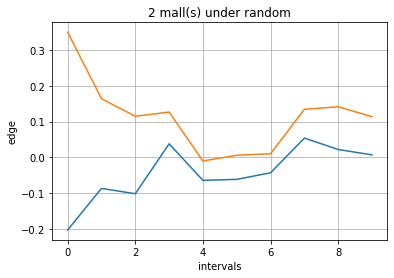

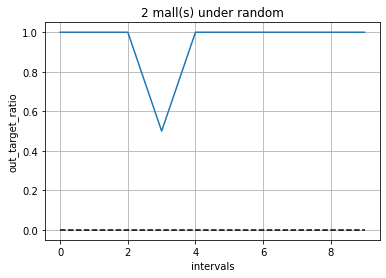

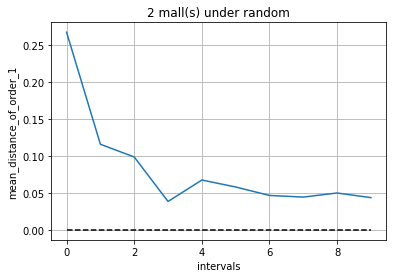

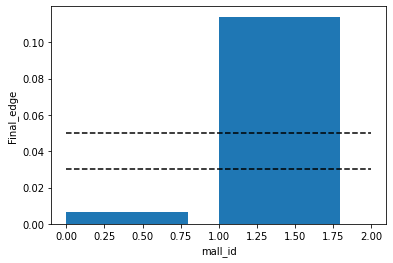

In [11]:
random_output()

In [12]:
%%capture func_1_output
%%time
game_run_choice_func_1(total_interval, n_action, n_mall, upper_bound, lower_bound)

final edges:[0.10450422317832649, 0.24454810200255525]
CPU times: user 4.84 s, sys: 62.7 ms, total: 4.9 s
Wall time: 4.99 s


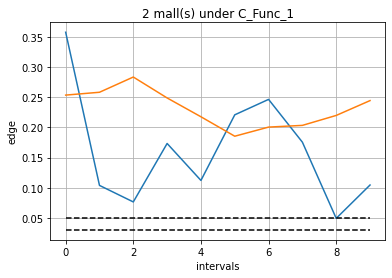

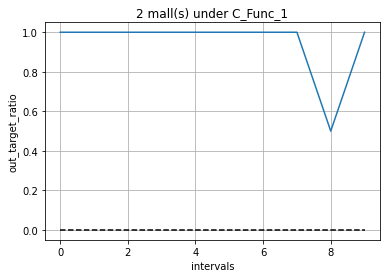

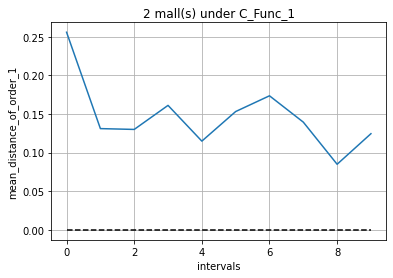

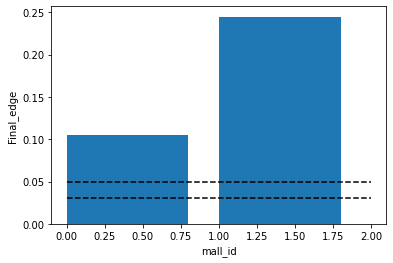

In [53]:
func_1_output()

In [13]:
%%capture func_2_output 
%%time
game_run_choice_func_2(total_interval, n_action, n_mall, upper_bound, lower_bound, P, Q)

final edges:[0.1013734453697813, 0.06550755165458975]
CPU times: user 3.88 s, sys: 71.6 ms, total: 3.95 s
Wall time: 3.95 s


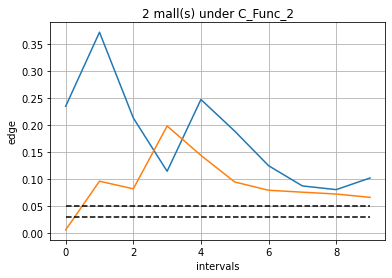

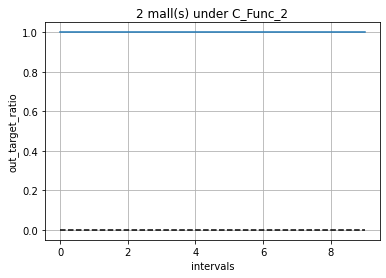

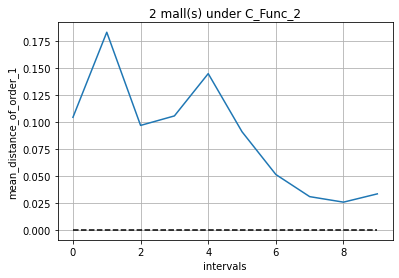

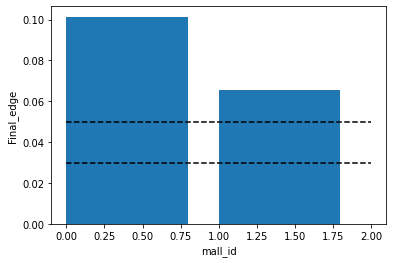

In [14]:
func_2_output() 

In [15]:
%%capture func_3_output 
%%time
game_run_choice_func_3(total_interval, n_action, n_mall, upper_bound, lower_bound)

final edges:[0.02746229856964343, 0.006278380319770112]
CPU times: user 3.68 s, sys: 52.5 ms, total: 3.73 s
Wall time: 3.73 s


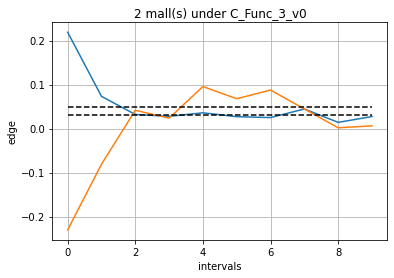

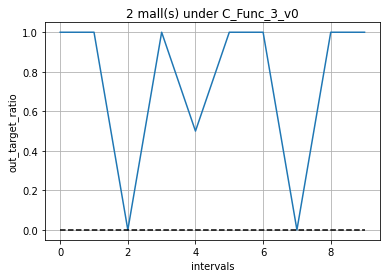

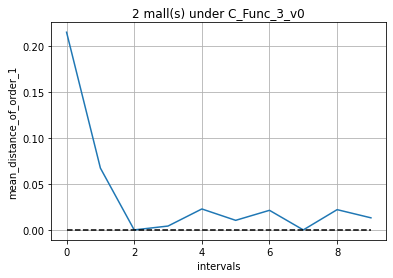

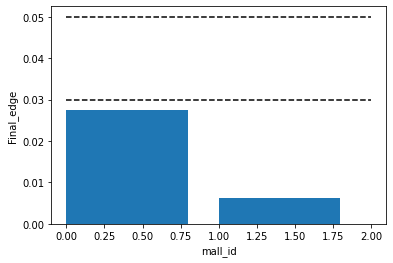

In [16]:
func_3_output() 

In [17]:
%%capture func_3_v1
%%time
game_run_choice_func_3_v1(total_interval, n_action, n_mall, upper_bound, lower_bound)

final edges:[0.0027006046164748786, 0.08611590323713265]
CPU times: user 3.81 s, sys: 57.5 ms, total: 3.87 s
Wall time: 3.86 s


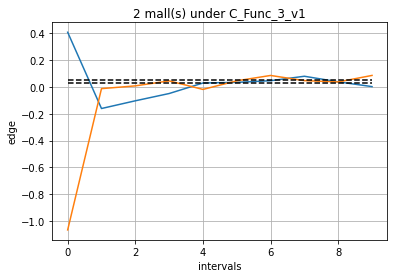

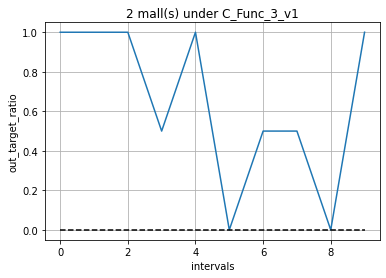

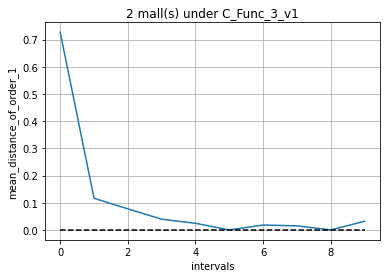

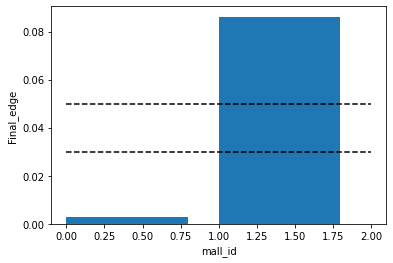

In [18]:
func_3_v1()